Comparando clasificadores. <br>

También implementado PCA y cross-validation.

En digits['images'] se encuentran las imágenes en matrices 8x8.
En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.
En digits['data'] se encuentra la información a entrenar. Tamaño: (1797, 64)
Ejemplo [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 



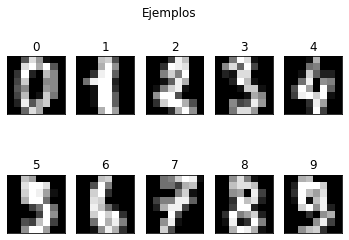

In [4]:
#Cargar dataset (Digits)
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

digits = datasets.load_digits()

print("En digits['images'] se encuentran las imágenes en matrices 8x8.")
print("En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.")
print(f"En digits['data'] se encuentra la información a entrenar. Tamaño: {digits['data'].shape}")
print("Ejemplo",digits["data"][0],"\n")

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(digits["images"][num],cmap='gray')
    ax.set_title(digits["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)



In [14]:
from sklearn.datasets import fetch_openml

#Imágenes 28x28 del MNIST de Yann Lecun
MNIST={}
MNIST["data"], MNIST["target"] = fetch_openml('mnist_784', return_X_y=True)

image_shape=(28,28)


f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(x[num],cmap='gray')
    ax.set_title(digits["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

NameError: name 'x' is not defined

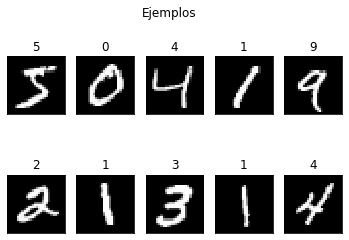

In [15]:

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(MNIST["data"][num].reshape(image_shape),cmap='gray')
    ax.set_title(MNIST["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

Balance de clases dentro del total de muestras


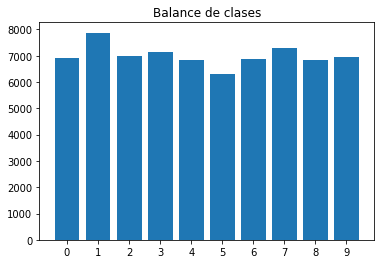

In [16]:
#Clases
plt.figure()
class_counts=np.unique(y, return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases")
print("Balance de clases dentro del total de muestras")

In [46]:
X=MNIST["data"][:7000]
y=MNIST["target"].astype(int)

print(np.unique(y))

[0 1 2 3 4 5 6 7 8 9]


Set de entrenamiento con el 75% de muestras: (3750, 784)
Balance de clases dentro del set de entrenamiento


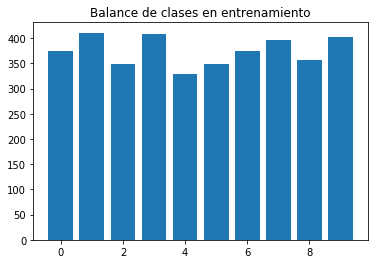

In [49]:
#Organizar train-test
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# #Para digits
# X=digits["data"]
# y=digits["target"]

#Para MNIST
#subsample para evitar quemar mi compu
X=MNIST["data"]
y=MNIST["target"].astype(int)
X,y=resample(X,y,n_samples=5000,replace=False,random_state=42)

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25)
print(f"Set de entrenamiento con el 75% de muestras: {X_train.shape}")

plt.figure()
class_counts=np.unique(y_train, return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases en entrenamiento")
print("Balance de clases dentro del set de entrenamiento")

Los primeros 84 componentes explican el 90.1% de la varianza de los dígitos.


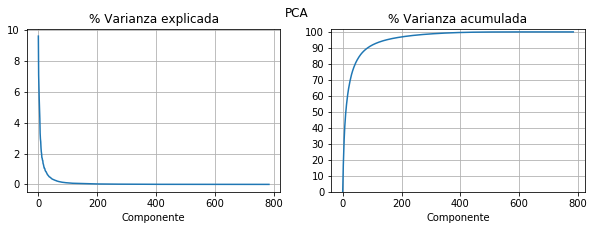

In [50]:
#PCA (tal vez buena idea hacer gridsearch para hallar número óptimo de parámetros)
from sklearn import decomposition
pca=decomposition.PCA()

train_size=X_train.shape
X_full=np.vstack([X_train,X_test])
y_full=np.hstack([y_train,y_test])
X_pca=pca.fit_transform(X_full)

f,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(100*pca.explained_variance_ratio_)
f.suptitle("PCA")
ax[0].set_title("% Varianza explicada")
ax[0].set_xlabel("Componente")
ax[0].grid()

varianza_acumulada=np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(100*np.concatenate([[0],varianza_acumulada]))
ax[1].set_title("% Varianza acumulada")
ax[1].set_xlabel("Componente")
ax[1].set_yticks(range(0,101,10))
ax[1].set_ylim(0,102)
ax[1].grid()

#Se busca el índice del PC desde desde el cual se ha explicado el 90% de la varianza
PCA_idx=np.argwhere(varianza_acumulada>0.90)[0][0]
X_pca=X_pca[:,:PCA_idx]

#recupera train-test
Xpca_train=X_pca[0:train_size[0],:]
Xpca_test=X_pca[train_size[0]:,:]

print(f"Los primeros {PCA_idx} componentes explican el {100*varianza_acumulada[PCA_idx]:.1f}% de la varianza de los dígitos.")

Separación de clases en los dos primeros componentes principales
Si únicamente se ven los dos primeros componentes, se confunden varios números


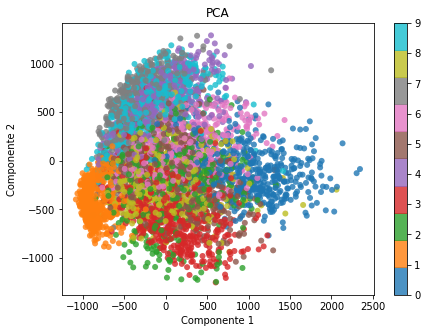

In [51]:
#Separación de componentes principales
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, edgecolor='none', alpha=0.8,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.title("PCA")
print("Separación de clases en los dos primeros componentes principales")
print("Si únicamente se ven los dos primeros componentes, se confunden varios números")

Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 2} con accuracy_score 97.70


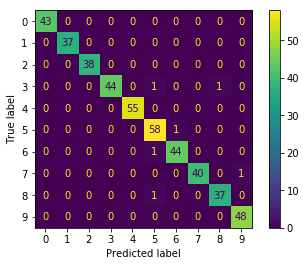

In [10]:
#Regresión logística sin PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])



param_grid = [{
    'poly__degree': [1,2],
    'logreg__C': [0.01,1,100],
}]


search_lr=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search_lr.fit(X_train,y_train)
metrics.plot_confusion_matrix(search_lr,X_test,y_test)
print(f"Mejores parámetros: {search_lr.best_params_} con accuracy_score {100*search_lr.best_score_:.2f}")

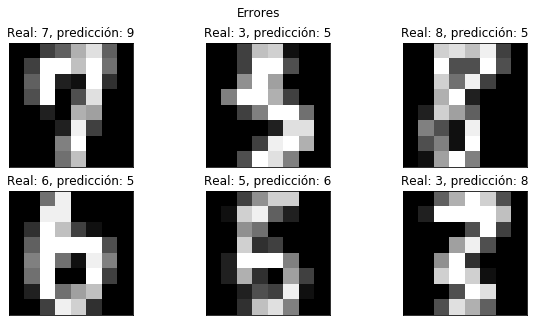

In [11]:
#Graficar las predicciones incorrectas
y_pred=search_lr.predict(X_test)

errores=np.where(y_pred!=y_test)[0].reshape(-1,3)

f,axes=plt.subplots(errores.shape[0],errores.shape[1],figsize=(10,5))
f.suptitle("Errores")
for num,ax in zip(errores.flatten(),axes.flatten()):
    ax.imshow(X_test[num].reshape(8,8),cmap='gray')
    ax.set_title(f"Real: {y_test[num]}, predicción: {y_pred[num]}")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 3} con accuracy_score 98.14


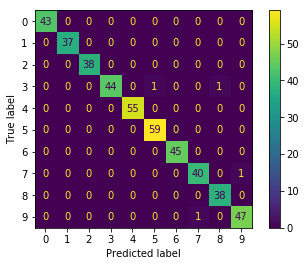

In [32]:
#Regresión logística con PCA
poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])

param_grid = [{
    'poly__degree': [1,2,3],
    'logreg__C': [0.01,1,100],
}]

search_lr_pca=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search_lr_pca.fit(Xpca_train,y_train)
metrics.plot_confusion_matrix(search_lr_pca,Xpca_test,y_test)
print(f"Mejores parámetros: {search_lr_pca.best_params_} con accuracy_score {100*search_lr_pca.best_score_:.2f}")


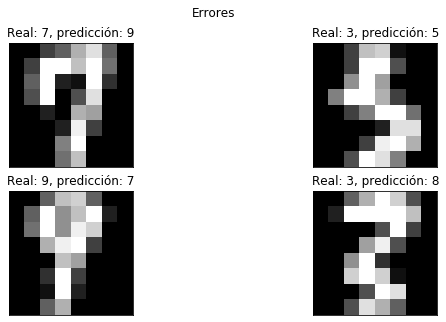

In [34]:
#Graficar las predicciones incorrectas
y_pred=search_lr_pca.predict(Xpca_test)

errores=np.where(y_pred!=y_test)[0].reshape(-1,2)

f,axes=plt.subplots(errores.shape[0],errores.shape[1],figsize=(10,5))
f.suptitle("Errores")
for num,ax in zip(errores.flatten(),axes.flatten()):
    ax.imshow(X_test[num].reshape(8,8),cmap='gray')
    ax.set_title(f"Real: {y_test[num]}, predicción: {y_pred[num]}")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)